In [1]:
import os.path as op
import sys
sys.path.append('../externals/hnn-core')

import numpy as np
import matplotlib.pyplot as plt

import hnn_core
from hnn_core import calcium_model, simulate_dipole, MPIBackend, read_params, jones_2009_model, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.viz import NetworkPlot, plot_cell_connectivity

In [2]:
def filter_connections(conn_dict, target_gids):
    filtered_gid_pairs = dict()
    filtered_src_gids = list()
    for src_gid, conn_target in conn_dict['gid_pairs'].items():
        if np.all(np.in1d(conn_target, target_gids)):
            filtered_gid_pairs[src_gid] = conn_target
        else:
            filtered_gid_pairs[src_gid] = []

    conn_dict['target_gids'] = target_gids.tolist()
    conn_dict['num_targets'] = len(target_gids)
    conn_dict['gid_pairs'] = filtered_gid_pairs

In [5]:
hnn_core_root = op.dirname(hnn_core.__file__)
params_fname = op.join(hnn_core_root, 'param', 'default.json')

params = read_params(params_fname)
params.update({'N_pyr_x': 2, 'N_pyr_y': 50})

net = calcium_model(params)
# net = jones_2009_model(params)
net.set_cell_positions(inplane_distance=10)

# Scale local network weights
exc_conns = pick_connection(net, src_gids=['L5_pyramidal', 'L2_pyramidal'])
for conn_idx in exc_conns:
    net.connectivity[conn_idx]['nc_dict']['A_weight'] *= 10.0

# Add drives to network
# weights_ampa_prox = {'L2_basket': 0.02, 'L2_pyramidal': 0.02,
#                 'L5_basket': 0.02, 'L5_pyramidal': 0.02}
# synaptic_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
#                    'L5_basket': 1.0, 'L5_pyramidal': 1.0}

# net.add_evoked_drive(name='evprox1', mu=20.0, sigma=2.0, numspikes=1,
#                      weights_ampa=weights_ampa_prox, location='proximal',
#                      synaptic_delays=synaptic_delays_prox, space_constant=100)

weights_ampa_noise = {'L2_basket': 0.01, 'L2_pyramidal': 0.002,
                      'L5_pyramidal': 0.02}
            

net.add_poisson_drive('noise_local', rate_constant=2., location='distal',
                       weights_ampa=weights_ampa_noise, space_constant=100,
                       n_drive_cells='n_cells', cell_specific=True)

# Using float rate constant breaks sim?

net.add_poisson_drive('noise_global', rate_constant=2, location='distal',
                       weights_ampa=weights_ampa_noise, space_constant=100,
                       n_drive_cells=1, cell_specific=False)


In [6]:
# for cell_type in net.cell_types.keys():
#     target_gids = np.array([net.gid_ranges[cell_type][0]])
#     conn_idx = pick_connection(net, src_gids='evprox1', target_gids=cell_type)
#     assert len(conn_idx) == 1
#     filter_connections(net.connectivity[conn_idx[0]], target_gids)

In [7]:
electrode_pos = [(10, pos, 0) for pos in np.arange(0, 1000, 10)]
net.add_electrode_array('shank1', electrode_pos)

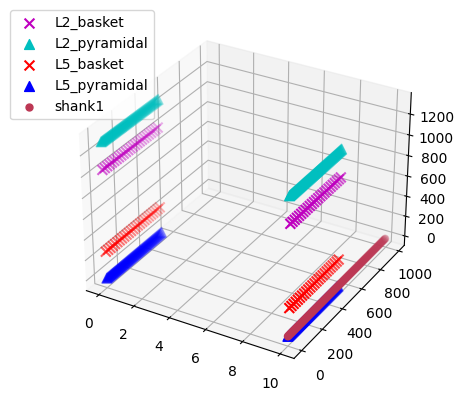

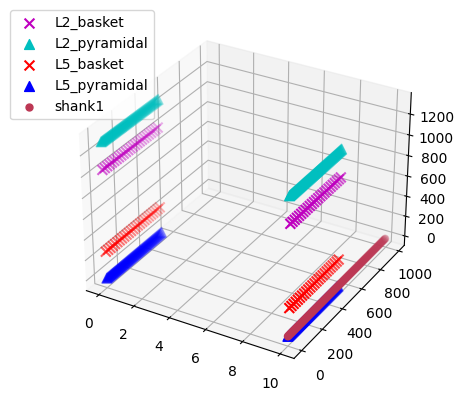

In [8]:
net.plot_cells()

In [9]:
# with MPIBackend(n_procs=8):
dpl = simulate_dipole(net, tstop=2000, dt=0.5, record_vsec='all')

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn_wave/notebooks/../externals/hnn-core/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...
Trial 1: 300.0 ms...
Trial 1: 310.0 ms...
Trial 1: 320.0 ms...
Trial 1: 330.0 ms...
Trial 1: 340.0 ms...
Trial 1: 350.0 ms...
Trial 1: 360

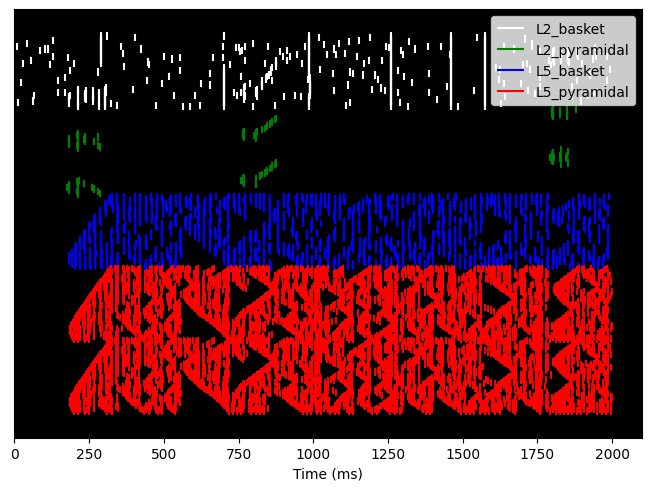

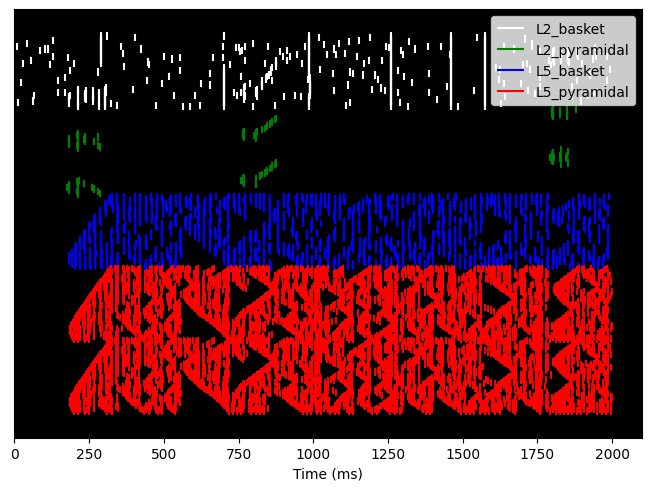

In [10]:
net.cell_response.plot_spikes_raster()

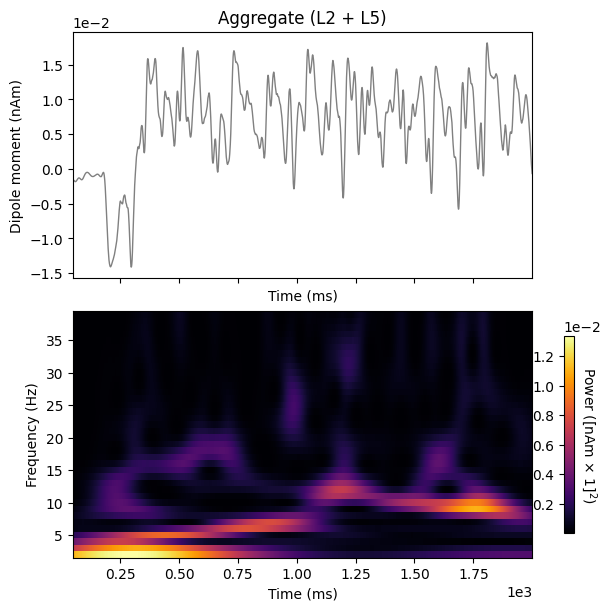

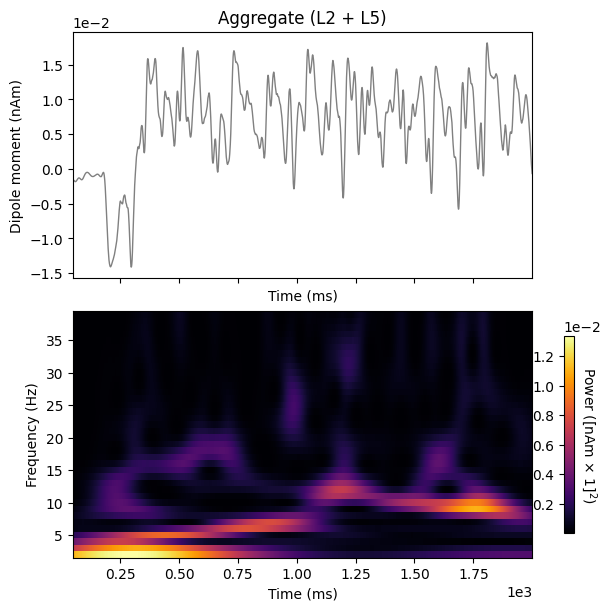

In [18]:
tmin = 50
trial_idx = 0  # pick first trial

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                         constrained_layout=True)

dpl[trial_idx].copy().smooth(30).plot(tmin=tmin, ax=axes[0], show=False)

# Create an fixed-step tiling of frequencies from 20 to 100 Hz in steps of 1 Hz
freqs = np.arange(2., 40., 1.)
dpl[trial_idx].copy().smooth(30).plot_tfr_morlet(freqs, n_cycles=7, tmin=tmin, ax=axes[1])

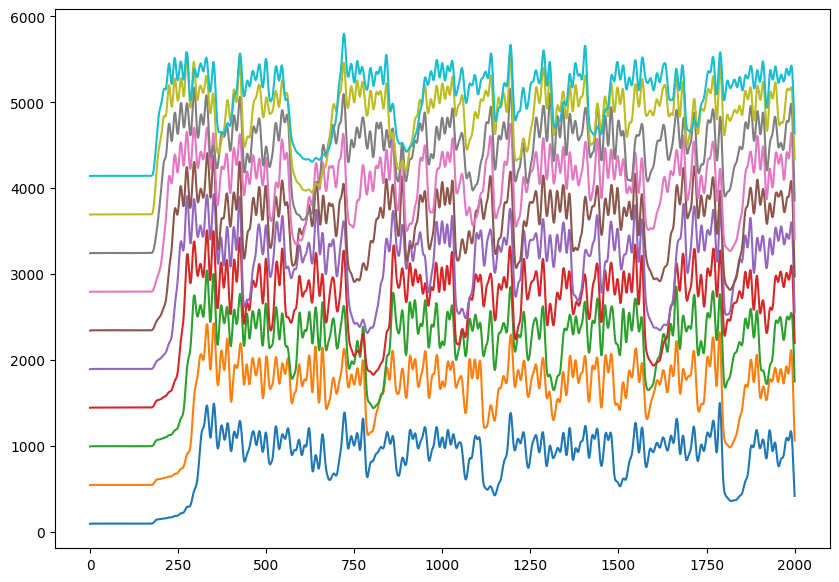

In [52]:
plt.figure(figsize=(10,7))
for e_idx in range(1,50,5):
    plot_data = net.rec_arrays['shank1'][trial_idx].copy().smooth(20).voltages[0,e_idx,:] + (e_idx * 90)
    plt.plot(net.cell_response.times, plot_data)

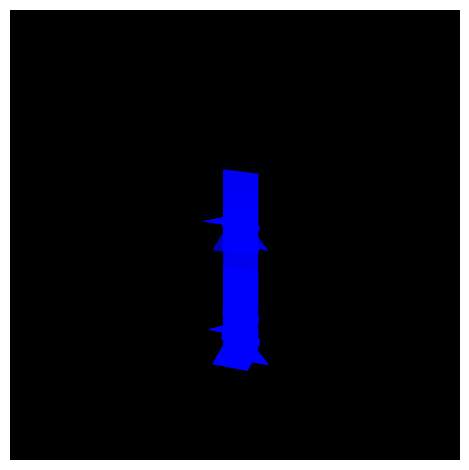

In [44]:
net_plot = NetworkPlot(net)


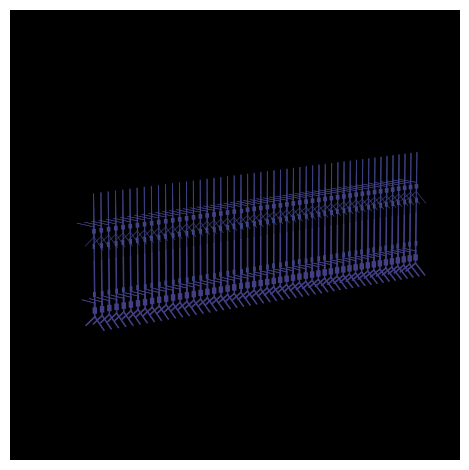

In [50]:
net_plot.azim = -400
net_plot.zlim = (-200, 3100)
net_plot.ylim = (-50, 250)
net_plot.xlim = (-200, 3100)
net_plot.set_time_idx(0)
net_plot.fig

In [51]:
net_plot.export_movie('beta_wave.mp4', dpi=200, decim=10, interval=1)

In [10]:
%matplotlib inline
for plot_idx, time_idx in enumerate(range(0, 4000, 10)):  
    net_plot.set_time_idx(0 + time_idx)
    net_plot.azim = -400
    net_plot.fig.savefig(f'../figures/fig{plot_idx}.png')


In [ ]:
net.cell_response